# Logistic Regression for MNIST Digit Classification

This notebook implements logistic regression with L2 regularization for binary classification of MNIST digits 3 and 8. It compares vanilla gradient descent and mini-batch stochastic gradient descent (SGD) optimization methods with different hyperparameter settings.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

rng = np.random.default_rng(3317)
plt.style.use("ggplot")


In [2]:
def load_mnist_3_8():
    """
    Load and preprocess MNIST dataset, filtering for digits 3 and 8.

    Returns:
        X_train, X_test, y_train, y_test: Training and test data and labels
    """
    # Load MNIST data
    mnist = fetch_openml("mnist_784", version=1)
    X, y = mnist.data.astype(float), mnist.target

    # Select only digits 3 and 8
    mask = (y == "3") | (y == "8")
    X, y = X.loc[mask].values, y.loc[mask].values

    # Convert labels to binary (0 for 3, 1 for 8)
    y = (y == "8").astype(int)

    # Normalize pixel values
    X = X / 255.0

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test


In [3]:
def visualize_samples(X, y, num_samples=5):
    """Visualize sample images from the dataset.

    Args:
        X: Features
        y: Labels (0 for digit 3, 1 for digit 8)
        num_samples: Number of samples to display from each class
    """
    # Find indices for each class
    indices_3 = np.where(y == 0)[0]
    indices_8 = np.where(y == 1)[0]

    # Randomly select samples
    np.random.seed(42)  # For reproducibility
    sample_indices_3 = np.random.choice(indices_3, num_samples, replace=False)
    sample_indices_8 = np.random.choice(indices_8, num_samples, replace=False)

    # Create a figure
    _, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # Plot digit 3 samples
    for i, idx in enumerate(sample_indices_3):
        axes[0, i].imshow(X[idx].reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")

    # Plot digit 8 samples
    for i, idx in enumerate(sample_indices_8):
        axes[1, i].imshow(X[idx].reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")

    plt.tight_layout()
    # plt.savefig("./figures/mnist_samples.pdf", dpi=600, bbox_inches="tight")
    plt.show()

In [4]:
def initialize_parameters(m=784):
    """
    Initialize the model parameters.

    Args:
        m: Number of features (784 for MNIST)

    Returns:
        w: Initial weights
        b: Initial bias
    """
    np.random.seed(42)
    w = np.random.randn(m) * 0.01  # Small random values
    b = 0.0
    return w, b


Dataset shapes: 
  X_train: (11172, 784)
  y_train: (11172,)
  X_test: (2794, 784)
  y_test: (2794,)

Class distribution:
  Training set: 5713 instances of digit 3, 5459 instances of digit 8
  Test set: 1428 instances of digit 3, 1366 instances of digit 8


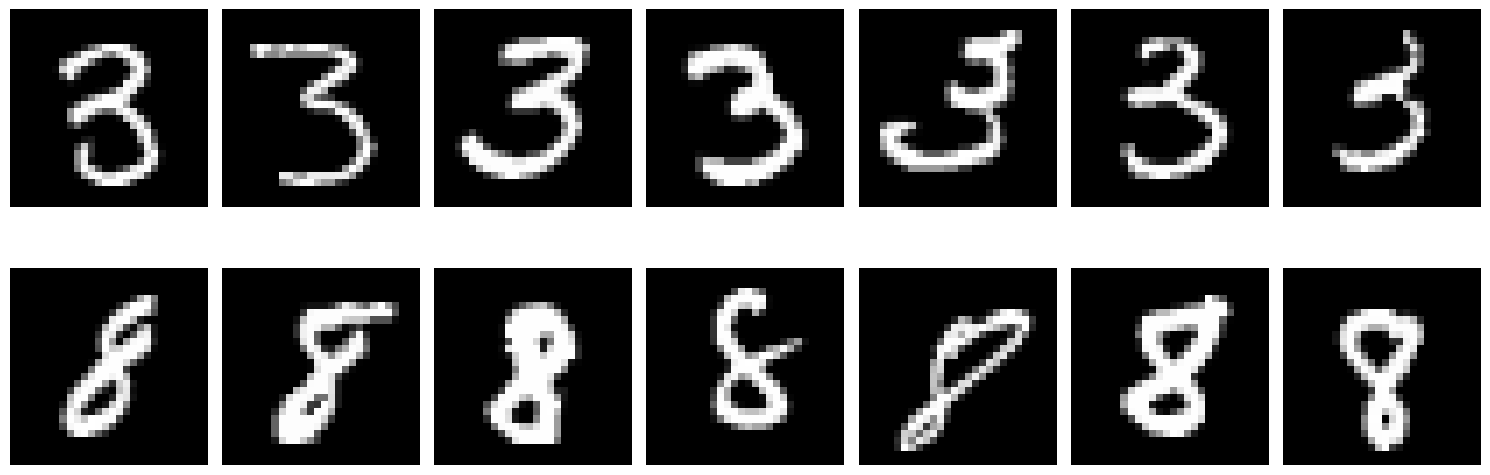

In [5]:
# Load and visualize dataset samples
X_train, X_test, y_train, y_test = load_mnist_3_8()
print(
    f"Dataset shapes: \n  X_train: {X_train.shape}\n  y_train: {y_train.shape}\n  X_test: {X_test.shape}\n  y_test: {y_test.shape}"
)

# Count class distribution in training and test sets
print(
    f"\nClass distribution:\n  Training set: {np.sum(y_train == 0)} instances of digit 3, {np.sum(y_train == 1)} instances of digit 8"
)
print(
    f"  Test set: {np.sum(y_test == 0)} instances of digit 3, {np.sum(y_test == 1)} instances of digit 8"
)

# Show sample images
visualize_samples(X_train, y_train, num_samples=7)

In [6]:
def sigmoid(z):
    """
    Numerically stable sigmoid activation function.

    Args:
        z: Input values

    Returns:
        Sigmoid values
    """
    # Clip to avoid overflow
    z = np.clip(z, -500, 500)

    # Separate computation for positive and negative values for numerical stability
    mask = z >= 0
    result = np.zeros_like(z, dtype=float)

    # For z >= 0: 1 / (1 + exp(-z))
    result[mask] = 1.0 / (1.0 + np.exp(-z[mask]))

    # For z < 0: exp(z) / (1 + exp(z)) to avoid large exp(-z)
    exp_z = np.exp(z[~mask])
    result[~mask] = exp_z / (1.0 + exp_z)

    return result

In [7]:
def predict(X, w, b):
    """
    Make predictions using the logistic regression model.

    Args:
        X: Features
        w: Weights
        b: Bias

    Returns:
        Predicted probabilities
    """
    z = np.dot(X, w) + b
    return sigmoid(z)


In [8]:
def compute_loss(X, y, w, b, mu):
    """
    Compute the cross-entropy loss with L2 regularization.

    Args:
        X: Features
        y: True labels
        w: Weights
        b: Bias
        mu: Regularization parameter

    Returns:
        Total loss value
    """
    p = predict(X, w, b)

    # Avoid log(0) errors
    p = np.clip(p, 1e-15, 1 - 1e-15)

    # Cross-entropy loss
    cross_entropy = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # L2 regularization
    regularization = (mu / 2) * (np.sum(w**2) + b**2)

    return cross_entropy + regularization


In [9]:
def compute_gradients(X, y, w, b, mu):
    """
    Compute the gradients of the loss function with respect to parameters.

    Args:
        X: Features
        y: True labels
        w: Weights
        b: Bias
        mu: Regularization parameter

    Returns:
        dw: Gradient with respect to w
        db: Gradient with respect to b
    """
    n = len(y)
    p = predict(X, w, b)

    # Gradient for w
    dw = np.dot(X.T, (p - y)) / n + mu * w

    # Gradient for b
    db = np.sum(p - y) / n + mu * b

    return dw, db


In [10]:
def visualize_misclassifications(X, y, w, b, num_examples=5):
    """
    Visualize examples that were misclassified by the model.

    Args:
        X: Features
        y: True labels
        w: Trained weights
        b: Trained bias
        num_examples: Number of misclassified examples to show
    """
    # Get predictions
    p = predict(X, w, b)
    y_pred = (p >= 0.5).astype(int)

    # Find misclassified examples
    misclassified = np.where(y_pred != y)[0]

    if len(misclassified) == 0:
        print("No misclassified examples found!")
        return

    # Select a subset of misclassified examples
    indices = misclassified[: min(num_examples, len(misclassified))]

    # Plot the examples
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    if len(indices) == 1:
        axes = [axes]

    for i, idx in enumerate(indices):
        img = X[idx].reshape(28, 28)
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(
            f"True: {3 if y[idx] == 0 else 8}\nPred: {3 if y_pred[idx] == 0 else 8}"
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [11]:
def train_model(
    X_train,
    y_train,
    learning_rate,
    num_epochs,
    mu,
    method="vanilla",
    batch_size=10,
    diminishing_lr=False,
    verbose=True,
):
    """
    Train a logistic regression model using either vanilla gradient descent or mini-batch SGD.

    Args:
        X_train: Training features
        y_train: Training labels
        learning_rate: Initial learning rate for gradient updates
        num_epochs: Number of training epochs
        mu: Regularization parameter
        method: 'vanilla' for vanilla gradient descent or 'sgd' for mini-batch SGD
        batch_size: Size of mini-batches (only used if method='sgd')
        diminishing_lr: If True, use diminishing learning rate gamma = learning_rate/t for SGD
        verbose: Whether to print progress

    Returns:
        w: Trained weights
        b: Trained bias
        loss_history: History of loss values during training
    """
    m = X_train.shape[1]  # Number of features (784 for MNIST)
    n = X_train.shape[0]  # Number of training examples

    # Initialize parameters
    w, b = initialize_parameters(m)

    # Initialize loss history
    loss_history = []

    # Loop over epochs
    for epoch in range(num_epochs):
        # Calculate current learning rate for SGD if using diminishing schedule
        current_lr = learning_rate
        if method == "sgd" and diminishing_lr:
            # t starts from 1, so epoch + 1
            current_lr = learning_rate / (epoch + 1)
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}: Current learning rate = {current_lr:.6f}")

        if method == "vanilla":
            # Vanilla gradient descent: compute gradients on entire dataset
            dw, db = compute_gradients(X_train, y_train, w, b, mu)

            # Update parameters
            w = w - learning_rate * dw
            b = b - learning_rate * db

        elif method == "sgd":
            # Mini-batch SGD: process data in batches

            # Shuffle data
            indices = np.random.permutation(n)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Process each mini-batch
            for i in range(0, n, batch_size):
                X_batch = X_shuffled[i : i + batch_size]
                y_batch = y_shuffled[i : i + batch_size]

                # Compute gradients on mini-batch
                dw, db = compute_gradients(X_batch, y_batch, w, b, mu)

                # Update parameters with current learning rate
                w = w - current_lr * dw
                b = b - current_lr * db
        else:
            raise ValueError("Method must be either 'vanilla' or 'sgd'")

        # Compute and store loss for the epoch
        loss = compute_loss(X_train, y_train, w, b, mu)
        loss_history.append(loss)

        # Print loss every 10 epochs as required
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")

    return w, b, loss_history

In [12]:
def evaluate(X, y, w, b):
    """
    Evaluate the model on a given dataset.

    Args:
        X: Features
        y: True labels
        w: Weights
        b: Bias

    Returns:
        accuracy: Classification accuracy
    """
    p = predict(X, w, b)
    y_pred = (p >= 0.5).astype(int)
    accuracy = np.mean(y_pred == y)
    return accuracy


In [13]:
def logistic_regression_mnist_3_8(
    learning_rate,
    mu,
    num_epochs=100,
    method="vanilla",
    batch_size=10,
    diminishing_lr=False,
    verbose=True,
    save_plots=False,
):
    """
    Train a logistic regression model to classify MNIST digits 3 and 8.

    Args:
        learning_rate: Initial learning rate for gradient descent
        mu: Regularization parameter
        num_epochs: Number of training epochs
        method: 'vanilla' for vanilla gradient descent or 'sgd' for mini-batch SGD
        batch_size: Size of mini-batches (only used if method='sgd')
        diminishing_lr: If True, use diminishing learning rate γ = learning_rate/t (only used if method='sgd')

    Returns:
        w: Trained weights
        b: Trained bias
        loss_history: Training loss after each epoch
        test_accuracy: Accuracy on the test set
    """
    # Load data
    X_train, X_test, y_train, y_test = load_mnist_3_8()

    lr_schedule = "diminishing" if diminishing_lr and method == "sgd" else "constant"
    print(
        f"Training with method={method}, learning_rate={learning_rate} ({lr_schedule}), mu={mu}"
    )
    print(f"Dataset shape: X_train: {X_train.shape}, y_train: {y_train.shape}")

    # Train the model
    w, b, loss_history = train_model(
        X_train,
        y_train,
        learning_rate,
        num_epochs,
        mu,
        method,
        batch_size,
        diminishing_lr,
        verbose=verbose,
    )

    # Evaluate on test set
    test_accuracy = evaluate(X_test, y_test, w, b)
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Plot loss history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    title = f"Training Loss (method={method}, ({lr_schedule}), mu={mu})"
    if lr_schedule is False:
        title = f"Training Loss (method={method}, lr={learning_rate} ({lr_schedule}), mu={mu})"
    plt.title(title)
    plt.grid(True)
    if save_plots:
        plt.savefig(
            f"./figures/{method}_{learning_rate}_{lr_schedule}.pdf",
            dpi=600,
            bbox_inches="tight",
        )
    plt.show()

    return w, b, loss_history, test_accuracy

In [14]:
def plot_learning_curves(results_dict, filename="learning_curves"):
    """
    Plot learning curves for multiple models side by side.

    Args:
        results_dict: Dictionary with model names as keys and (loss_history, params) as values
                     where params is a dictionary of hyperparameters
    """
    plt.figure(figsize=(12, 8))

    for model_name, (loss_history, params) in results_dict.items():
        epochs = range(1, len(loss_history) + 1)
        plt.plot(epochs, loss_history, label=model_name)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./figures/{filename}.pdf", dpi=600, bbox_inches="tight")
    plt.show()

In [15]:
def compare_methods_and_hyperparameters(
    methods=["vanilla"],
    learning_rates=[0.001],
    batch_sizes=[10],
    mu=1.0,
    epochs=1000,
    diminishing_lr=False,
    verbose=True,
    save_plots=False,
):
    """
    Compare vanilla gradient descent and mini-batch SGD with different hyperparameters.

    Args:
        methods: List of optimization methods to compare ('vanilla' or 'sgd')
        learning_rates: List of learning rates to test
        batch_sizes: List of batch sizes to test (only applicable for 'sgd')
        mu: Regularization parameter
        epochs: Number of training epochs
        diminishing_lr: Whether to use diminishing learning rate for SGD
        verbose: Whether to print progress during training

    Returns:
        results: List of dictionaries with results for each configuration
        models_info: Dictionary with model names as keys and (weights, bias, loss_history) as values
        best_w: Weights of the best performing model
        best_b: Bias of the best performing model
        comparison_data: Data for comparison plots
    """

    results = []
    models_info = {}
    best_accuracy = 0
    best_model_name = ""
    best_w, best_b = None, None

    for method in methods:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                # Only consider batch sizes for SGD
                if method == "vanilla" and batch_size != batch_sizes[0]:
                    continue

                model_name = f"{method}_lr_{lr}"
                if method == "sgd":
                    model_name += f"_bs_{batch_size}"
                if diminishing_lr and method == "sgd":
                    model_name += "_dim"

                print(f"\nTraining with {model_name}, mu={mu}")

                w, b, loss_history, test_accuracy = logistic_regression_mnist_3_8(
                    lr,
                    mu,
                    num_epochs=epochs,
                    method=method,
                    batch_size=batch_size,
                    diminishing_lr=diminishing_lr,
                    verbose=verbose,
                    save_plots=save_plots,
                )

                # Store detailed results
                result = {
                    "model_name": model_name,
                    "method": method,
                    "learning_rate": lr,
                    "batch_size": batch_size if method == "sgd" else "N/A",
                    "diminishing_lr": diminishing_lr if method == "sgd" else "N/A",
                    "mu": mu,
                    "num_epochs": epochs,
                    "final_loss": loss_history[-1],
                    "test_accuracy": test_accuracy,
                }

                results.append(result)

                # Store model parameters and loss history
                models_info[model_name] = (w, b, loss_history)

                # Track best model
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_model_name = model_name
                    best_w, best_b = w, b

    # Print results table
    print("\nResults Summary:")
    print("-" * 100)
    print(
        f"{'Model':<20}{'Method':<10}{'Learning Rate':<15}{'Batch Size':<15}{'Final Loss':<15}{'Test Accuracy':<15}"
    )
    print("-" * 100)
    for result in results:
        print(
            f"{result['model_name']:<20}{result['method']:<10}{result['learning_rate']:<15}{result['batch_size']:<15}"
            f"{result['final_loss']:<15.4f}{result['test_accuracy']:<15.4f}"
        )

    print(f"\nBest model: {best_model_name} with test accuracy: {best_accuracy:.4f}")

    # Prepare data for comparison plots
    comparison_data = {}
    for name, (_, _, loss_hist) in models_info.items():
        comparison_data[name] = (loss_hist, {})

    return results, models_info, best_w, best_b, comparison_data



=== Question 3: Single Model Experiments ===

1. Training with vanilla gradient descent:
Training with method=vanilla, learning_rate=0.001 (constant), mu=1
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Epoch 10/1200, Loss: 0.7333
Epoch 20/1200, Loss: 0.7244
Epoch 30/1200, Loss: 0.7159
Epoch 40/1200, Loss: 0.7077
Epoch 50/1200, Loss: 0.7000
Epoch 60/1200, Loss: 0.6925
Epoch 70/1200, Loss: 0.6853
Epoch 80/1200, Loss: 0.6785
Epoch 90/1200, Loss: 0.6720
Epoch 100/1200, Loss: 0.6657
Epoch 110/1200, Loss: 0.6597
Epoch 120/1200, Loss: 0.6539
Epoch 130/1200, Loss: 0.6484
Epoch 140/1200, Loss: 0.6431
Epoch 150/1200, Loss: 0.6380
Epoch 160/1200, Loss: 0.6332
Epoch 170/1200, Loss: 0.6285
Epoch 180/1200, Loss: 0.6240
Epoch 190/1200, Loss: 0.6197
Epoch 200/1200, Loss: 0.6156
Epoch 210/1200, Loss: 0.6116
Epoch 220/1200, Loss: 0.6078
Epoch 230/1200, Loss: 0.6042
Epoch 240/1200, Loss: 0.6006
Epoch 250/1200, Loss: 0.5973
Epoch 260/1200, Loss: 0.5940
Epoch 270/1200, Loss: 0.5909
Epoch 280/120

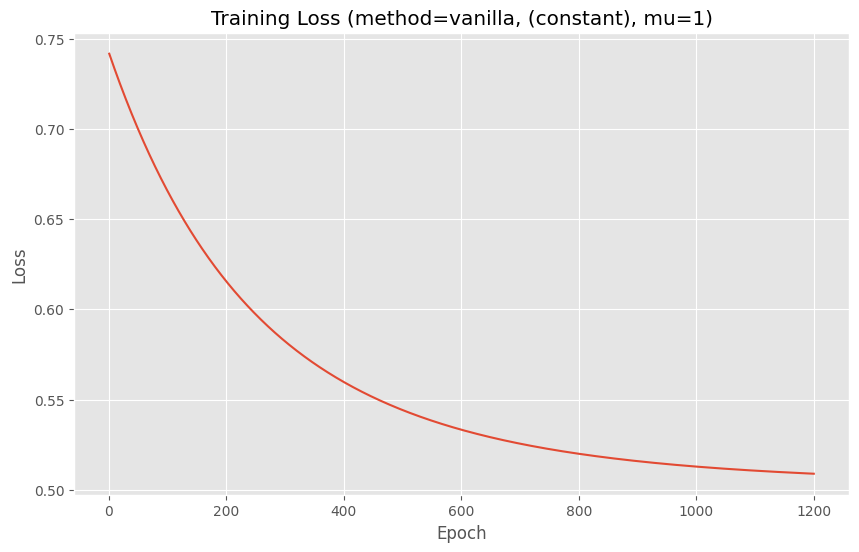


2. Training with mini-batch SGD (constant learning rate):
Training with method=sgd, learning_rate=0.001 (constant), mu=1
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Epoch 10/100, Loss: 0.5031
Epoch 20/100, Loss: 0.5031
Epoch 30/100, Loss: 0.5031
Epoch 40/100, Loss: 0.5032
Epoch 50/100, Loss: 0.5032
Epoch 60/100, Loss: 0.5032
Epoch 70/100, Loss: 0.5031
Epoch 80/100, Loss: 0.5031
Epoch 90/100, Loss: 0.5031
Epoch 100/100, Loss: 0.5031
Test accuracy: 0.9205


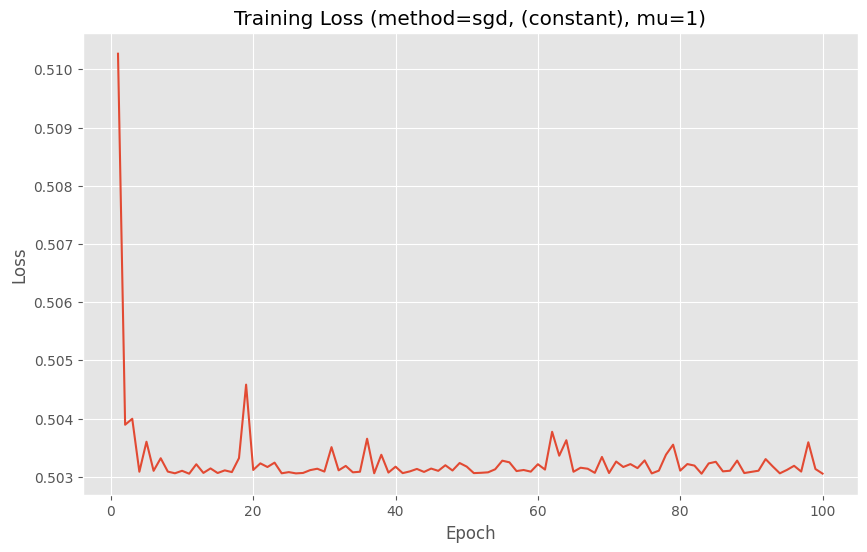


=== Question 4: Learning Rate Experiments ===

Comparing different learning rates for Gradient Descent:

Training with vanilla_lr_0.0001, mu=1.0
Training with method=vanilla, learning_rate=0.0001 (constant), mu=1.0
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.8486


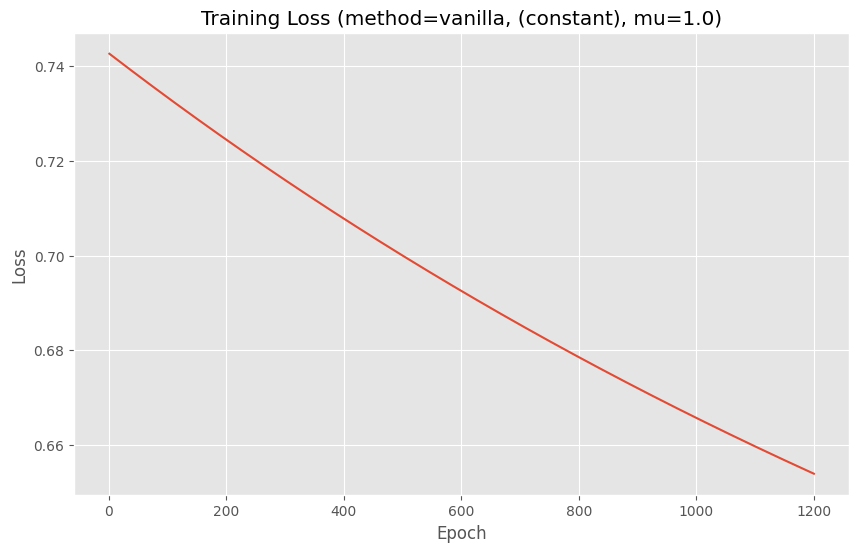


Training with vanilla_lr_0.001, mu=1.0
Training with method=vanilla, learning_rate=0.001 (constant), mu=1.0
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.9102


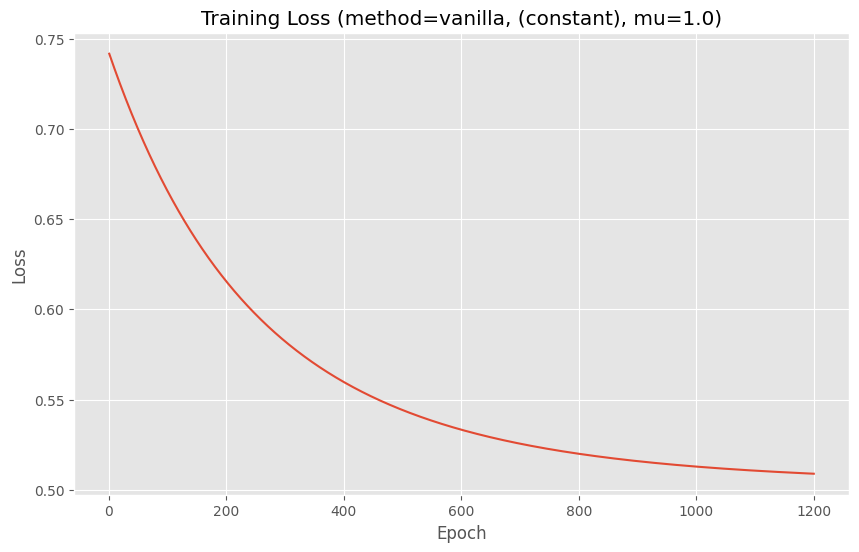


Training with vanilla_lr_0.01, mu=1.0
Training with method=vanilla, learning_rate=0.01 (constant), mu=1.0
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.9202


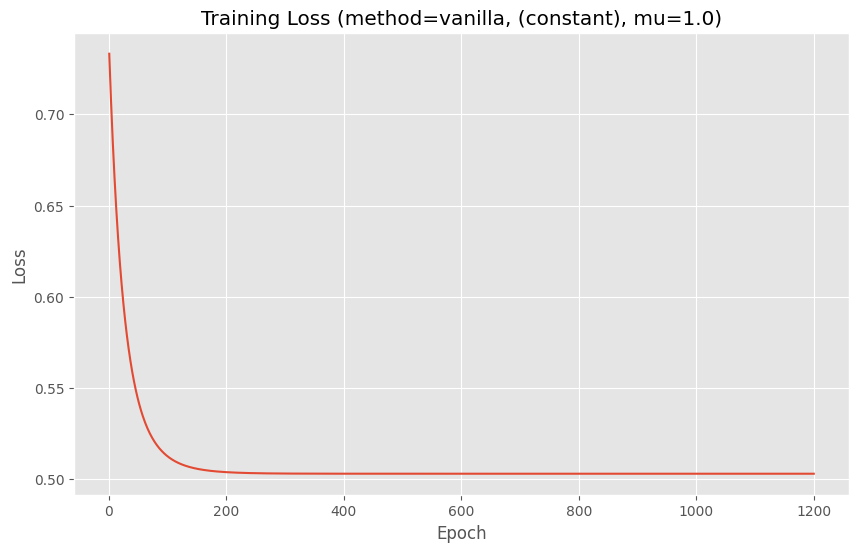


Results Summary:
----------------------------------------------------------------------------------------------------
Model               Method    Learning Rate  Batch Size     Final Loss     Test Accuracy  
----------------------------------------------------------------------------------------------------
vanilla_lr_0.0001   vanilla   0.0001         N/A            0.6540         0.8486         
vanilla_lr_0.001    vanilla   0.001          N/A            0.5089         0.9102         
vanilla_lr_0.01     vanilla   0.01           N/A            0.5030         0.9202         

Best model: vanilla_lr_0.01 with test accuracy: 0.9202


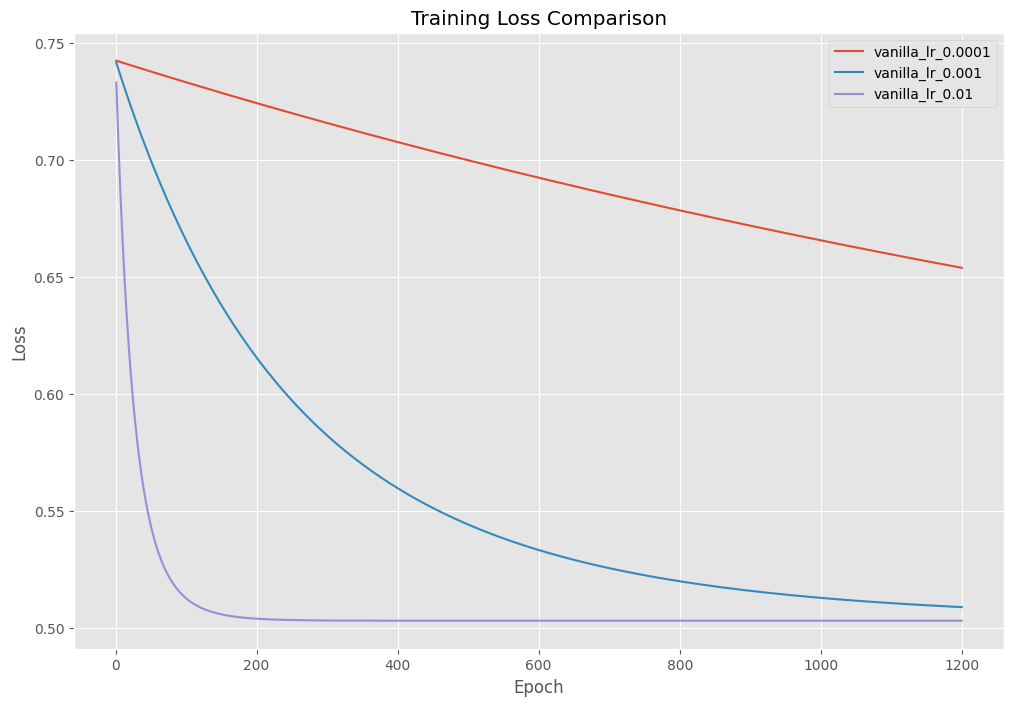


Comparing different learning rates for SGD:

Training with sgd_lr_0.0001_bs_10, mu=1.0
Training with method=sgd, learning_rate=0.0001 (constant), mu=1.0
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.9198


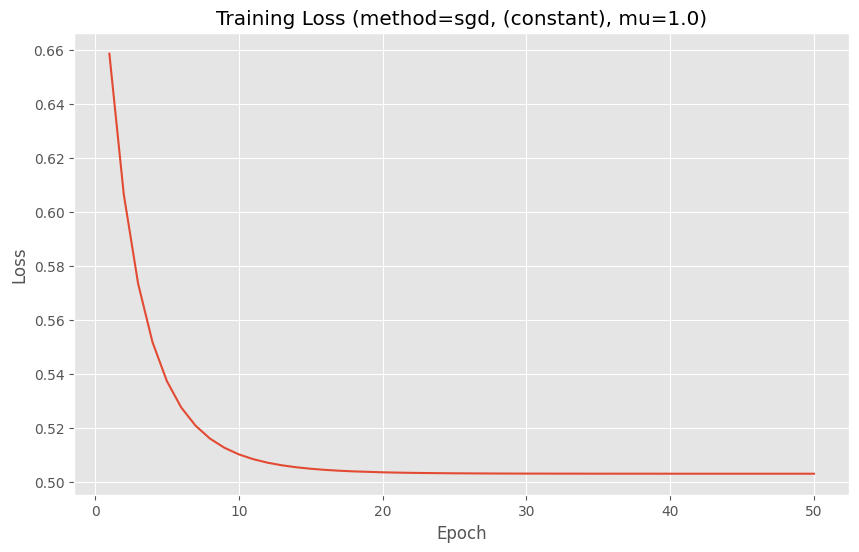


Training with sgd_lr_0.001_bs_10, mu=1.0
Training with method=sgd, learning_rate=0.001 (constant), mu=1.0
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.9234


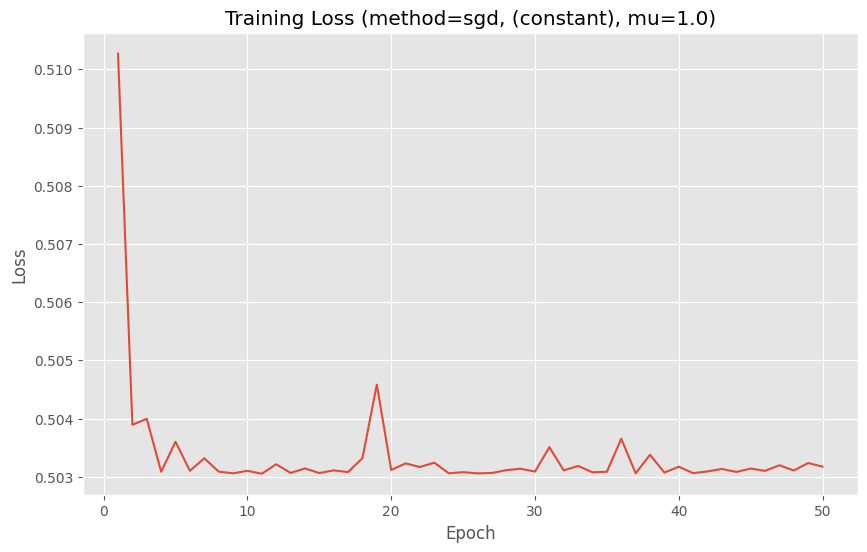


Training with sgd_lr_0.01_bs_10, mu=1.0
Training with method=sgd, learning_rate=0.01 (constant), mu=1.0
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.9166


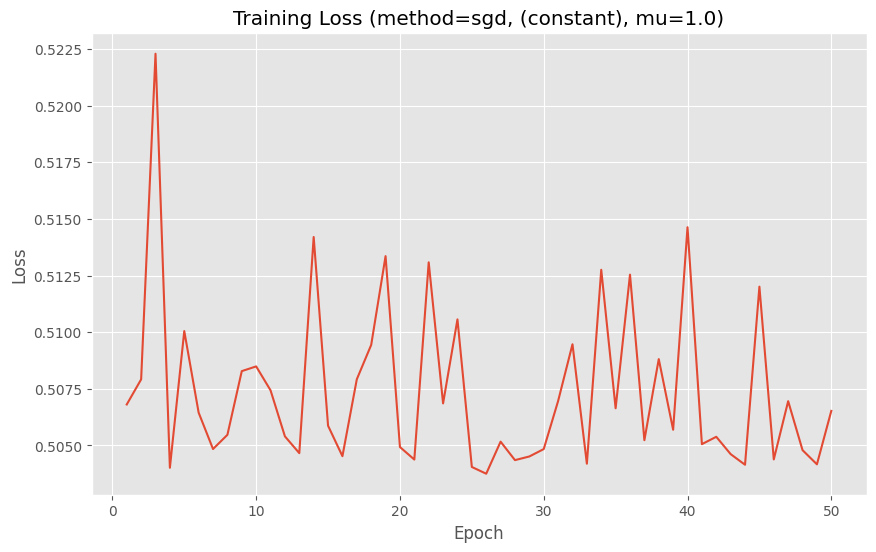


Results Summary:
----------------------------------------------------------------------------------------------------
Model               Method    Learning Rate  Batch Size     Final Loss     Test Accuracy  
----------------------------------------------------------------------------------------------------
sgd_lr_0.0001_bs_10 sgd       0.0001         10             0.5030         0.9198         
sgd_lr_0.001_bs_10  sgd       0.001          10             0.5032         0.9234         
sgd_lr_0.01_bs_10   sgd       0.01           10             0.5065         0.9166         

Best model: sgd_lr_0.001_bs_10 with test accuracy: 0.9234


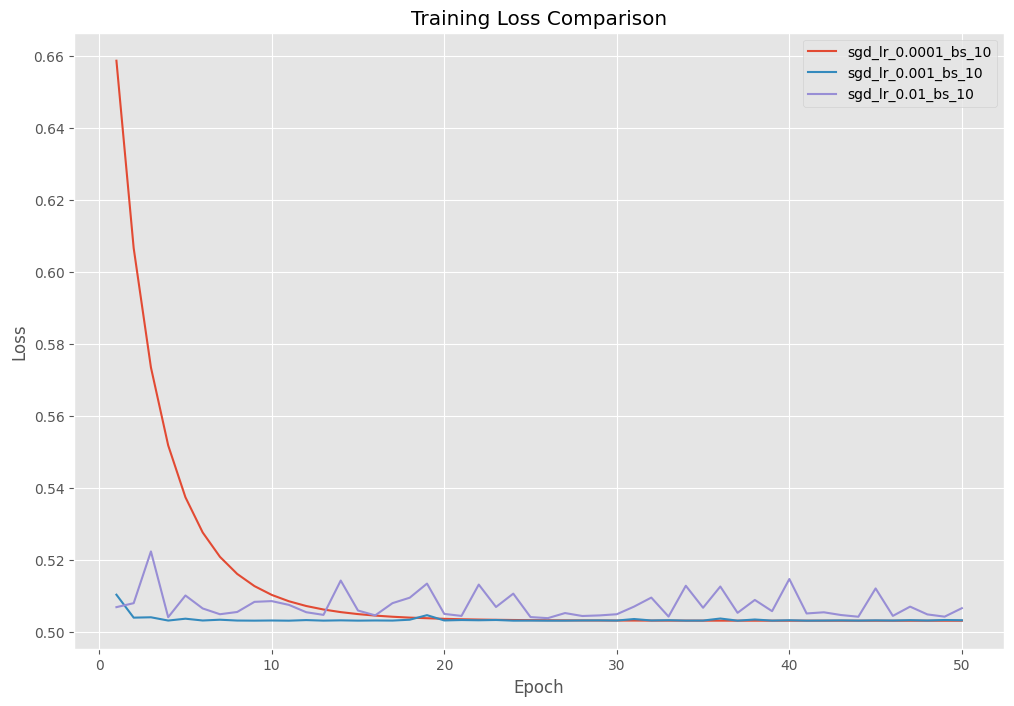


=== Question 5: Batch size Experiments ===

Comparing different batch sizes for SGD:

Training with sgd_lr_0.001_bs_1, mu=1.0
Training with method=sgd, learning_rate=0.001 (constant), mu=1.0
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.9177


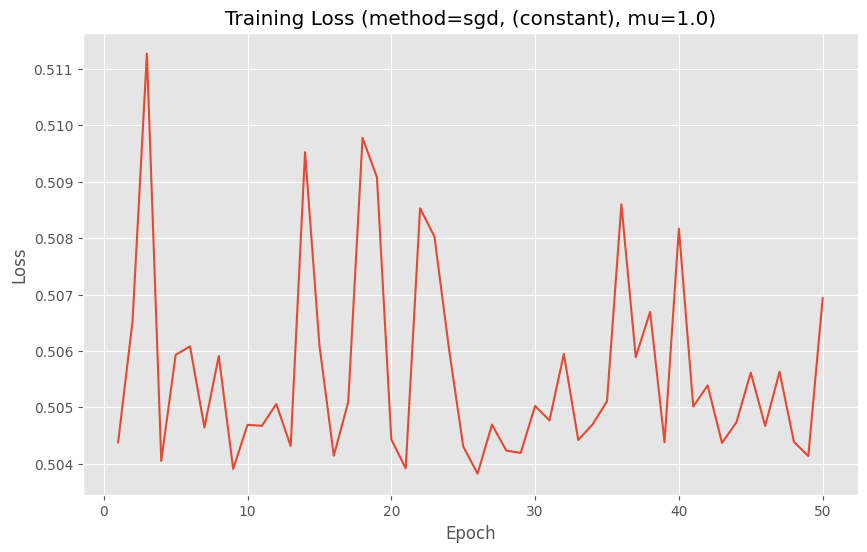


Training with sgd_lr_0.001_bs_10, mu=1.0
Training with method=sgd, learning_rate=0.001 (constant), mu=1.0
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.9234


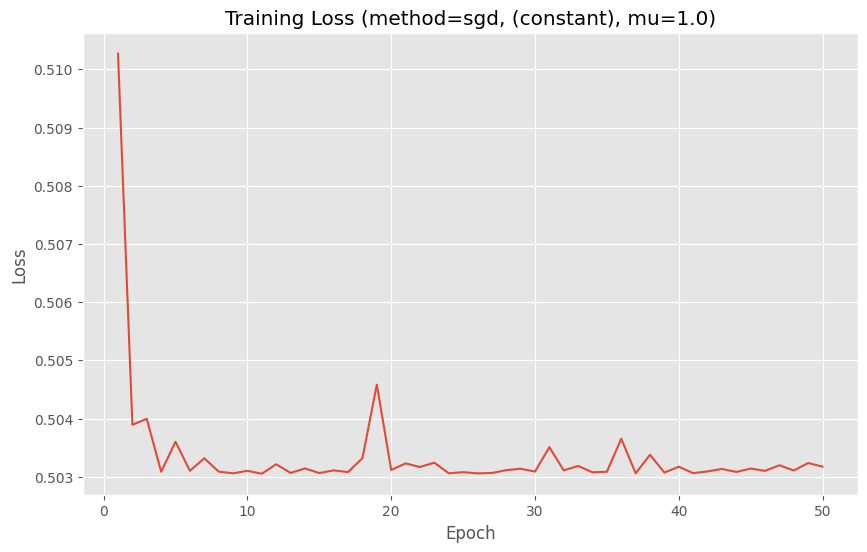


Training with sgd_lr_0.001_bs_100, mu=1.0
Training with method=sgd, learning_rate=0.001 (constant), mu=1.0
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.9202


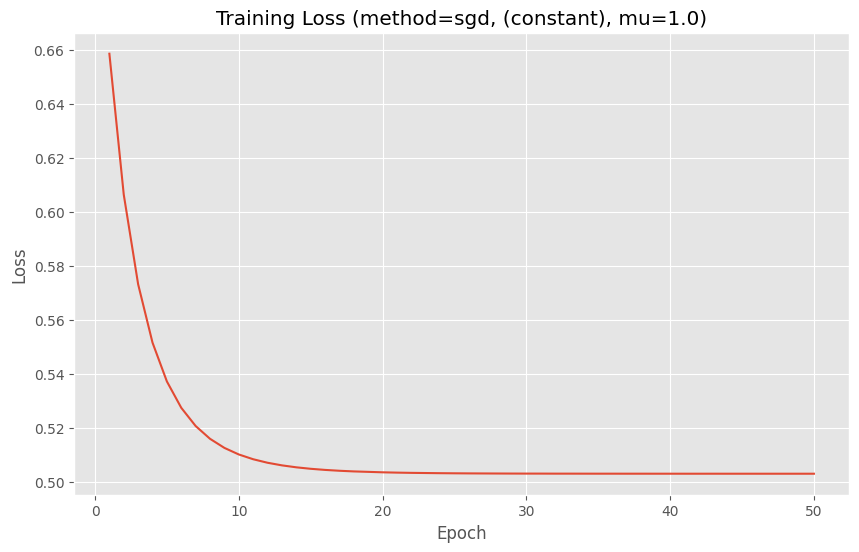


Results Summary:
----------------------------------------------------------------------------------------------------
Model               Method    Learning Rate  Batch Size     Final Loss     Test Accuracy  
----------------------------------------------------------------------------------------------------
sgd_lr_0.001_bs_1   sgd       0.001          1              0.5069         0.9177         
sgd_lr_0.001_bs_10  sgd       0.001          10             0.5032         0.9234         
sgd_lr_0.001_bs_100 sgd       0.001          100            0.5030         0.9202         

Best model: sgd_lr_0.001_bs_10 with test accuracy: 0.9234


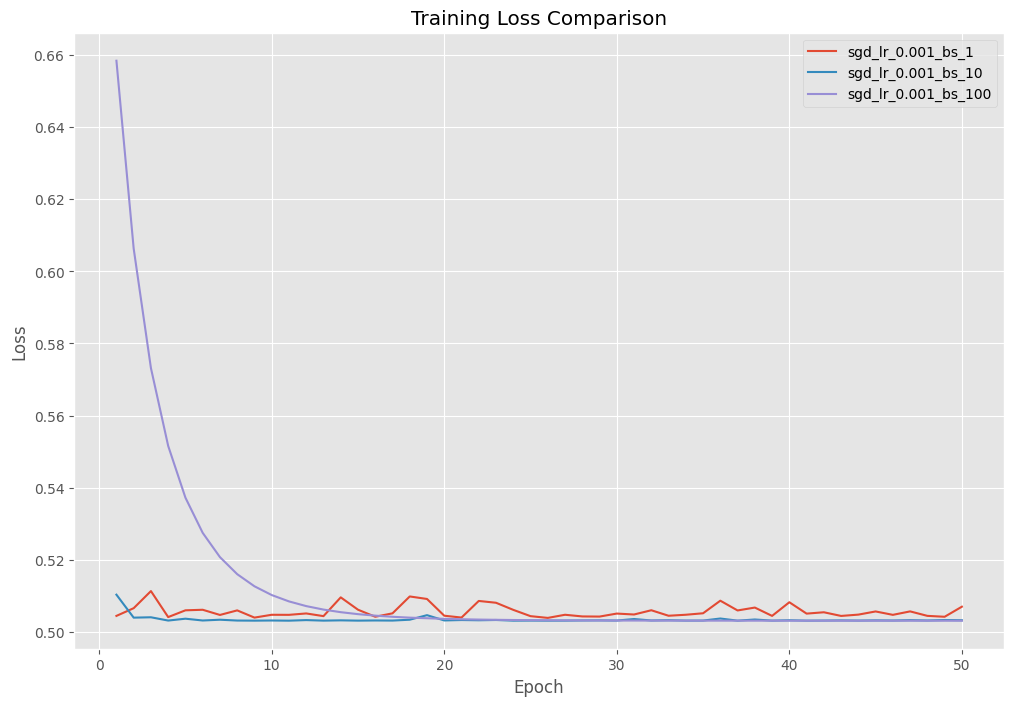


=== Question 6: diminishing learning rate ===
Training with mini-batch SGD (diminishing learning rate):
Training with method=sgd, learning_rate=0.001 (diminishing), mu=1
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.9202


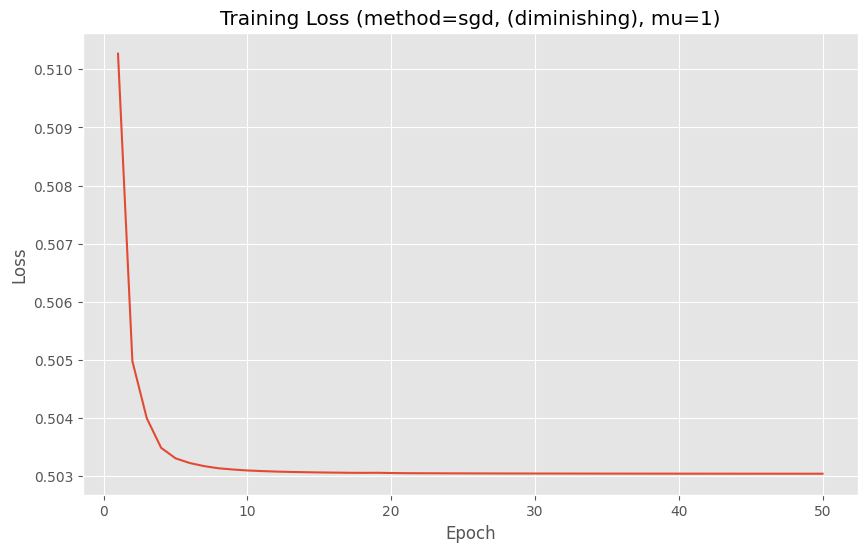

Training with mini-batch SGD (constant learning rate):
Training with method=sgd, learning_rate=0.001 (constant), mu=1
Dataset shape: X_train: (11172, 784), y_train: (11172,)
Test accuracy: 0.9234


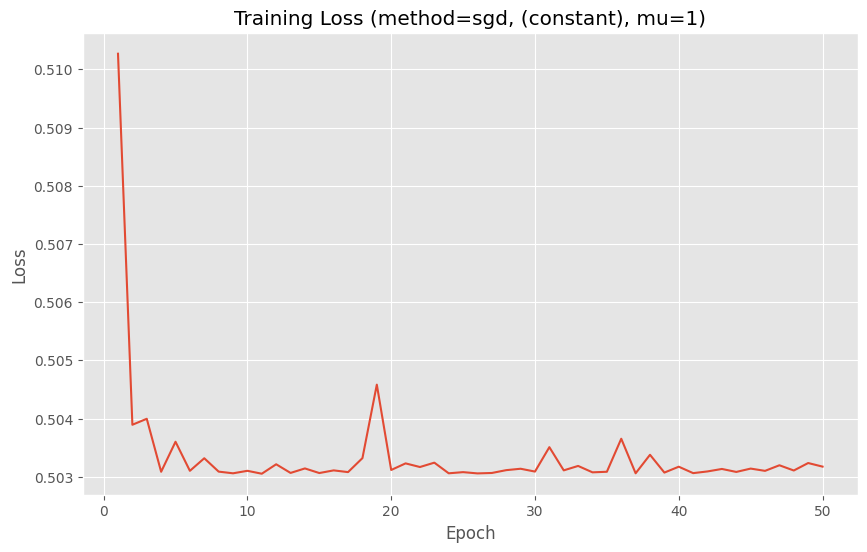

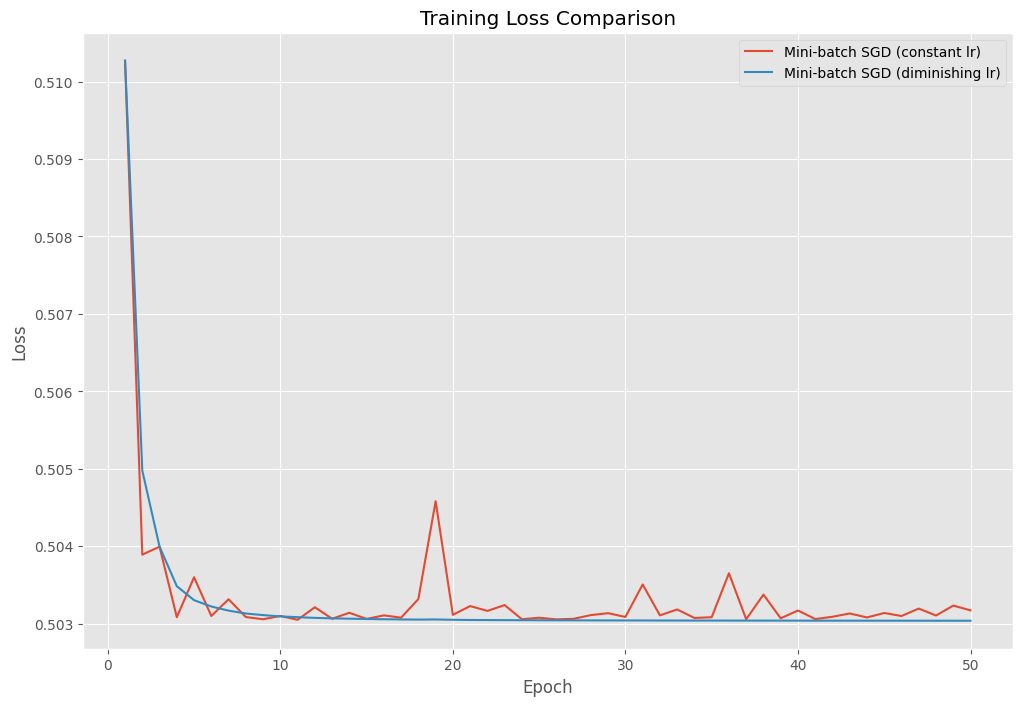

In [16]:
if __name__ == "__main__":
    # Question 3: Single model experiments
    print("\n=== Question 3: Single Model Experiments ===")

    mu = 1  # Regularization parameter

    learning_rate = 0.001
    print("\n1. Training with vanilla gradient descent:")
    w_vanilla, b_vanilla, loss_vanilla, test_acc_vanilla = (
        logistic_regression_mnist_3_8(
            learning_rate, mu, num_epochs=1200, method="vanilla"
        )
    )

    # Single run with mini-batch SGD (constant learning rate)
    print("\n2. Training with mini-batch SGD (constant learning rate):")
    w_sgd, b_sgd, loss_sgd, test_acc_sgd = logistic_regression_mnist_3_8(
        learning_rate, mu, num_epochs=100, method="sgd", batch_size=10
    )

    # Question 4: Learning rate impact on GD
    print("\n=== Question 4: Learning Rate Experiments ===")

    print("\nComparing different learning rates for Gradient Descent:")
    results1, models1, best_w1, best_b1, comp_data1 = (
        compare_methods_and_hyperparameters(
            methods=["vanilla"],
            learning_rates=[0.0001, 0.001, 0.01],
            batch_sizes=[10],
            epochs=1200,
            diminishing_lr=False,
            verbose=False,
            save_plots=False,
        )
    )
    plot_learning_curves(comp_data1, "gc_learning_rates")

    print("\nComparing different learning rates for SGD:")
    results1, models1, best_w1, best_b1, comp_data1 = (
        compare_methods_and_hyperparameters(
            methods=["sgd"],
            learning_rates=[0.0001, 0.001, 0.01],
            batch_sizes=[10],
            epochs=50,
            diminishing_lr=False,
            verbose=False,
            save_plots=False,
        )
    )
    plot_learning_curves(comp_data1, "sgd_learning_rates")

    # Question 5: Batch size impact on SGD
    print("\n=== Question 5: Batch size Experiments ===")

    print("\nComparing different batch sizes for SGD:")
    results1, models1, best_w1, best_b1, comp_data1 = (
        compare_methods_and_hyperparameters(
            methods=["sgd"],
            learning_rates=[0.001],
            batch_sizes=[1, 10, 100],
            epochs=50,
            diminishing_lr=False,
            verbose=False,
            save_plots=False,
        )
    )
    plot_learning_curves(comp_data1, "q5_sgd_batch_sizes")

    # Question 6: diminishing learning rate impact on SGD
    print("\n=== Question 6: diminishing learning rate ===")

    # Single run with mini-batch SGD (diminishing learning rate)
    print("Training with mini-batch SGD (diminishing learning rate):")
    _, _, loss_sgd_dim, _ = logistic_regression_mnist_3_8(
        0.001,
        mu,
        num_epochs=50,
        method="sgd",
        batch_size=10,
        diminishing_lr=True,
        verbose=False,
        save_plots=False,
    )

    print("Training with mini-batch SGD (constant learning rate):")
    _, _, loss_sgd, _ = logistic_regression_mnist_3_8(
        0.001,
        mu,
        num_epochs=50,
        method="sgd",
        batch_size=10,
        diminishing_lr=False,
        verbose=False,
        save_plots=False,
    )

    # Compare learning curves
    single_models = {
        "Mini-batch SGD (constant lr)": (loss_sgd, {}),
        "Mini-batch SGD (diminishing lr)": (loss_sgd_dim, {}),
    }
    plot_learning_curves(single_models)


---
* __Author__: Carsten Jørgensen 
* __Date__: May 2025  
* __Course__: Machine Learning B  
* __Assignment__: Homework 3